# Creating Models to Predict Customer Churn
## The process to create a predictive model is as follows...
### - Aquire the Data
- Access the database from SQL and store into a pandas dataframe
- Split the data into train, test, and validate

### - Prep the Data (stored in prepare.py or done in notebook)
- Deal with missing values identified in preparation.ipynb
- Create columns for new features, such as dummy variables or derived variables

### -  Split the Data
#### Train
- 70 percent of the data
- Create models using different types (logistic regression, decision tree, etc.)
- Adjust parameters of each model
- Identify top 3 models used on train data

#### Validate
- 20 percent of the data
- Determine if the models created on train overfit to the data
- Determine the top 1 model

#### Test
- 10 percent of the data
- Test only on the best model
- Simulates real world, unseen data

### - Explore the Data
- Exploration on the train data set only, the rest of the data remains unseen
- Identify Predictor Variables (X) and Target Variable (y)
- Univariate Analysis (one variable)
    - For continuous variables, what is the central tendency/range and are there any outliers/missing values?
    - For discrete variables, how are they distributed?
- Bivariate Analysis (more than one variable)
    - Using hypothesis testing, are there any variables with a strong relationship?
    
### - Create Models
- Baseline is the best guess, we want our model to perform better than this


### - Form Conclusions

# Imports

In [1]:
# python files that contain the functions to aquire and prep the data
import acquire
import prepare

# import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ignoring warnings
import warnings
warnings.filterwarnings("ignore")

# importing hypothesis tests
from scipy.stats import chi2_contingency
from scipy.stats import ttest_1samp

# importing functions to create the various models
# this project will use classification machine learning:
# Logistic Regression, Decision Tree, Random Forest, and K-Nearest Neighbor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# importing functions to access model metrics, such as accuracy and the confusion matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print('Imports complete.')

Imports complete.


# Acquire

In [2]:
# aquiring data and using head to check everything is good
df = acquire.get_churn_data()
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,contract_type,payment_type,internet_service_type
0,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,No,...,Yes,1,No,2,59.9,542.4,No,Month-to-month,Mailed check,DSL
1,0013-MHZWF,Female,0,No,Yes,9,Yes,No,1,No,...,Yes,1,Yes,4,69.4,571.45,No,Month-to-month,Credit card (automatic),DSL
2,0015-UOCOJ,Female,1,No,No,7,Yes,No,1,Yes,...,No,1,Yes,1,48.2,340.35,No,Month-to-month,Electronic check,DSL
3,0023-HGHWL,Male,1,No,No,1,No,No phone service,1,No,...,No,1,Yes,1,25.1,25.1,Yes,Month-to-month,Electronic check,DSL
4,0032-PGELS,Female,0,Yes,Yes,1,No,No phone service,1,Yes,...,No,1,No,3,30.5,30.5,Yes,Month-to-month,Bank transfer (automatic),DSL


In [ ]:
# Pr

In [3]:
# prep the data with the Prepare file
df = prepare.prep_telco_df(df)

No duplicates found.
Dummy variables for gender created as "male".
Yes/No column values changed to boolean, 0 as no and 1 as yes
Combined variable for phone_service + multiple lines created.
Combined variable for partner + dependents created.
Simplified features: security, backup, protection, support, contract, internet type, and payment type.
Added feature for tenure in years.
Converted total_charges to float for easier manipulation.
Data prep complete.




In [4]:
train, test, validate = prepare.train_test_validate(df)

train shape:  (5070, 22) , validate shape:  (1268, 22) , test shape:  (705, 22)

train percent:  72.0 , validate percent:  18.0 , test percent:  10.0


# Explore data
- determine if more prep is needed
    - do we need other dummy variables
- determine X and y variables

In [5]:
# a look at each feature
# Churn is the target (y) variable, it is what we are trying to predict
train.head(3).T

,855,2823,5656
customer_id,6923-EFPNL,2004-OCQXK,2542-HYGIQ
senior_citizen,0,0,0
tenure_months,4,1,1
phone_service,2,1,1
online_security,0,0,0
online_backup,0,0,0
device_protection,0,0,0
tech_support,0,0,0
streaming_tv,0,0,0
streaming_movies,0,1,0


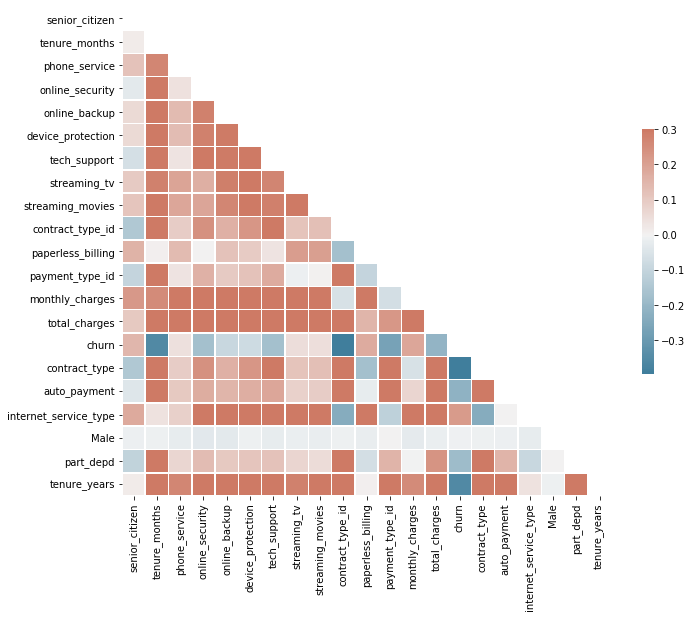

In [6]:
# Correlation heat map
# creating the correlation of each feature against each other
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Takeaways
- highest correlation are the darker blue or red colors
- the darkest colors associated with churn are 
    - contract type
    - tenure
    - charges
    - payment type
    - tech support

# Tech Support
- Does tech support reduce churn?
- The correlation map above suggested a slight correlation, let's test a hypothesis with chi-squared
    - Null hypothesis: churn is independent from tech support
    - Alternative hypothesis: churn is dependent on tech support

In [7]:
# NOT CONTROLLING FOR SERVICE TYPE
# creating a cross tab of customers with/without tech support and is/is not churned
observed1 = pd.crosstab(train.tech_support, train.churn)

# scipy function calculates values based on the crosstab created
chi2, p, degf, expected = chi2_contingency(observed1)

print('Observed\n')
print(observed1.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[2474 1134]
 [1246  216]]
---
Expected

[[2647.28994083  960.71005917]
 [1072.71005917  389.28994083]]
---

chi^2 = 146.8825
p     = 0.0000


In [9]:
# for reference on layout of observed table
observed1

churn,0,1
tech_support,,
0,2474,1134
1,1246,216


In [8]:
# CONTROLLING FOR SERVICE TYPE
# Only customers with internet service can choose tech support, would calculating on internet customers change anything

train_internet = train[train.internet_service_type != 0]

# creating a cross tab of customers with/without tech support and is/is not churned from only internet service customers
observed2 = pd.crosstab(train_internet.tech_support, train_internet.churn)

# scipy function calculates values based on the crosstab created
chi2, p, degf, expected = chi2_contingency(observed2)

print('Observed\n')
print(observed2.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[1484 1046]
 [1246  216]]
---
Expected

[[1730.18537074  799.81462926]
 [ 999.81462926  462.18537074]]
---

chi^2 = 301.3286
p     = 0.0000


In [10]:
# for reference on layout of observed table
observed2

churn,0,1
tech_support,,
0,1484,1046
1,1246,216


### Takeaways
- The chi-squared statistic is a single number that tells you how much difference exists between your observed counts and the counts you would expect if there were no relationship at all in the population
- This number is higher when controlling for internet service only customers
- This shows the difference between churn or not is higher when all customers have the option
- Churn rate for all customers when not having tech support = .31
- Churn rate for internet custoemrs when not having tech support = .41

# Automatic Payment

# Service Type